# Medical images segmentation: Attention Unet architecture

The dataset we’ll use consists of 20 medical examinations in 3D, it contains the source images as well as the masks of segmentation of the liver for each. The data is available in NifTi format.  
The Attention Unet information: https://arxiv.org/abs/1804.03999  
The dataset information: https://www.ircad.fr/fr/recherche/3d-ircadb-01-fr/  







Firstly, we download the dataset.  
Project structure  
/raw  
    /train  
    /test  

In [1]:

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1s6rVJCSaMl6mOoFzjwkPvQamUTS4dqDi' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1s6rVJCSaMl6mOoFzjwkPvQamUTS4dqDi" -O data.py && rm -rf /tmp/cookies.txt

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YzxkCEdjeqjCNHUI1do6TWRr77P20xSc' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1YzxkCEdjeqjCNHUI1do6TWRr77P20xSc" -O raw.rar && rm -rf /tmp/cookies.txt
!unrar x -y raw.rar


--2021-03-23 08:47:35--  https://docs.google.com/uc?export=download&confirm=&id=1s6rVJCSaMl6mOoFzjwkPvQamUTS4dqDi
Resolving docs.google.com (docs.google.com)... 142.250.73.206, 2607:f8b0:4004:829::200e
Connecting to docs.google.com (docs.google.com)|142.250.73.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-30-docs.googleusercontent.com/docs/securesc/8ksc22l2ja5m3sqilnndlnn4fkpt30nt/2nmo08obr3uk9jr8uaimk4tq6dqdlvhb/1616489250000/13136210922944487810/06711977778993065756Z/1s6rVJCSaMl6mOoFzjwkPvQamUTS4dqDi?e=download [following]
--2021-03-23 08:47:35--  https://doc-0k-30-docs.googleusercontent.com/docs/securesc/8ksc22l2ja5m3sqilnndlnn4fkpt30nt/2nmo08obr3uk9jr8uaimk4tq6dqdlvhb/1616489250000/13136210922944487810/06711977778993065756Z/1s6rVJCSaMl6mOoFzjwkPvQamUTS4dqDi?e=download
Resolving doc-0k-30-docs.googleusercontent.com (doc-0k-30-docs.googleusercontent.com)... 172.217.15.97, 2607:f8b0:4004:811::2001
Connecting to doc-0k-30-

**Data preprocessing**  
We’ll transform the 3-dimensional data into 2-d cuts. Then save them in “.npy” format.  
**Model**  
We train the model using Attention Unet then output the predition in preds/ directory.  


------------------------------
Creating training data...
------------------------------
Saving to .npy files done.
------------------------------
Creating test data...
------------------------------
ircad_e14_liver.nii.gz
(512, 512, 113)
ircad_e15_liver.nii.gz
(512, 512, 125)
ircad_e19_orig.nii.gz
(512, 512, 124)
ircad_e20_liver.nii.gz
(512, 512, 225)
ircad_e16_liver.nii.gz
(512, 512, 155)
ircad_e18_liver.nii.gz
(512, 512, 74)
ircad_e16_orig.nii.gz
(512, 512, 155)
ircad_e15_orig.nii.gz
(512, 512, 125)
ircad_e14_orig.nii.gz
(512, 512, 113)
ircad_e18_orig.nii.gz
(512, 512, 74)
ircad_e19_liver.nii.gz
(512, 512, 124)
ircad_e17_orig.nii.gz
(512, 512, 119)
ircad_e20_orig.nii.gz
(512, 512, 225)
ircad_e17_liver.nii.gz
(512, 512, 119)
Saving to .npy files done.
------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting mo

------------------------------
Saving predicted masks to files...
------------------------------


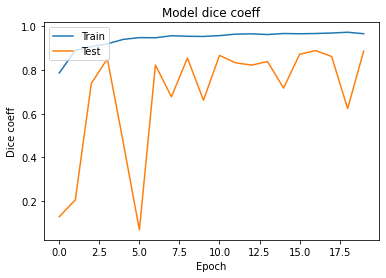

In [69]:
from __future__ import print_function
import keras.layers as layers
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
import matplotlib.pyplot as plt
from data import load_train_data, load_test_data, create_train_data, create_test_data

K.set_image_data_format('channels_last')  # TF dimension ordering in this code
create_train_data()
create_test_data()
img_rows = 256
img_cols = 256
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
class attention_unet():
  def __init__(self,img_rows=256,img_cols=256):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.img_shape=(self.img_rows,self.img_cols,1)
    self.df=64
    self.uf=64
    
  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False,name = False):
      if(name == True):
        d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same',name = 'lastconv')(layer_input)
      else:
        d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      
      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)
      
      return d
    
    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      if bn:
        u=layers.BatchNormalization()(u)
      u=layers.Activation('relu')(u)
      
      return u
    
    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      if bn:
        g=layers.BatchNormalization()(g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      if bn:
        x=layers.BatchNormalization()(x)
#       print(g.shape)
#       print(x.shape)
      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)
      
      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)
      
      if bn:
        psi=layers.BatchNormalization()(psi)
      psi=layers.Activation('sigmoid')(psi)
      
      return layers.Multiply()([F_l,psi])
    
    inputs=layers.Input(shape=self.img_shape)
    
    conv1=conv2d(inputs,self.df)
    pool1=layers.MaxPooling2D((2,2))(conv1)
    
    conv2=conv2d(pool1,self.df*2,bn=True)
    pool2=layers.MaxPooling2D((2,2))(conv2)
    
    conv3=conv2d(pool2,self.df*4,bn=True)
    pool3=layers.MaxPooling2D((2,2))(conv3)
    
    conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
    pool4=layers.MaxPooling2D((2,2))(conv4)
    
    conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)
    
    up6=deconv2d(conv5,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)
    
    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)
    
    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)
    
    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf,name = True)
    
    outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)
    
    model=Model(inputs=inputs,outputs=outputs)
    

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
    return model

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = load_train_data()

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std
    #Normalization of the train set

    imgs_mask_train = imgs_mask_train.astype('float32')

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    Net=attention_unet()
    model=Net.build_unet()
    
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)
    #Saving the weights and the loss of the best predictions we obtained

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    history=model.fit(imgs_train, imgs_mask_train, batch_size=10, epochs=20, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])

    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    imgs_test, imgs_maskt = load_test_data()
    imgs_test = preprocess(imgs_test)

    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std
    #Normalization of the test set

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)

    for k in range(len(imgs_mask_test)):
        a=rescale_intensity(imgs_test[k][:,:,0],out_range=(-1,1))
        b=(imgs_mask_test[k][:,:,0]).astype('uint8')
        io.imsave(os.path.join(pred_dir, str(k) + '_pred.png'),mark_boundaries(a,b))
    #Saving our predictions in the directory 'preds'
    plt.plot(history.history['dice_coef'])
    plt.plot(history.history['val_dice_coef'])
    plt.title('Model dice coeff')
    plt.ylabel('Dice coeff')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    #plotting our dice coeff results in function of the number of epochs

train_and_predict()

Model test dice coefficient : 0.88  
Yellow is the liver which has been predicted by the algorithm.  
Segmentation results:

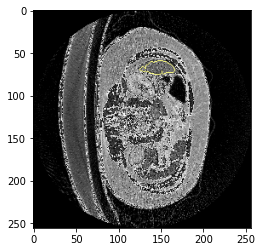

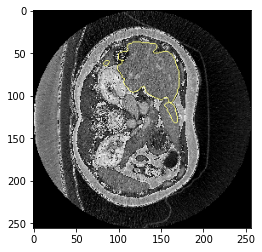

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("preds/305_pred.png")
   
plt.imshow(img)
plt.show()
img = mpimg.imread("preds/455_pred.png")
   
plt.imshow(img)
plt.show()

**Explainable AI**  
Now i will use GradCam to explain why the model output this result.  
Grad CAM visualizations are class-discriminative and localize relevant image regions but do not highlight the fine-grained pixel importance like guided backpropagation; however, unlike CAM, Grad CAM applies to any CNN architecture.  


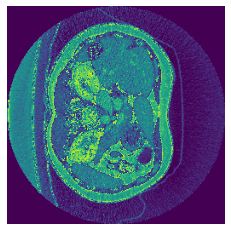

In [71]:
imgs_test, imgs_maskt = load_test_data()
imgs_test = preprocess(imgs_test)

imgs_test = imgs_test.astype('float32')
i = imgs_test[455]
i = i[:,:,0]
imgplot = plt.imshow(i)
plt.axis("off")
plt.show()

I create model from UNet until the last convolutional layer. Conv layers retain the spatial information which is lost when we apply the fully connected layer in the deep learning CNN model.

In [73]:
import tensorflow as tf
Net=attention_unet()
model=Net.build_unet()
model.load_weights('weights.h5', by_name=True)
gb_model = tf.keras.models.Model(
    inputs = [model.inputs],    
    outputs = [model.get_layer("lastconv").output]
)

layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]


In [74]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad
def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i], (img_cols, img_rows), preserve_range=True)

    imgs_p = imgs_p[..., np.newaxis]
    return imgs_p
imgs_test, imgs_maskt = load_test_data()
imgs_test = preprocess(imgs_test)

imgs_test = imgs_test.astype('float32')
img = imgs_test[455]
preprocessed_input = np.expand_dims(img, axis=0)

In [75]:
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu
with tf.GradientTape() as tape:
 inputs = tf.cast(preprocessed_input, tf.float32)
 tape.watch(inputs)
 outputs = gb_model(inputs)[0]
grads = tape.gradient(outputs,inputs)[0]



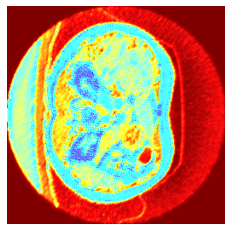

In [76]:
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2

weights = tf.reduce_mean(grads, axis=(0, 1))
grad_cam = np.ones(outputs.shape[0: 2], dtype = np.float32)
for i, w in enumerate(weights):
    grad_cam += w * outputs[:, :, i]
grad_cam_img = cv2.resize(grad_cam.numpy(), (256, 256))
grad_cam_img = np.maximum(grad_cam_img, 0)
heatmap = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
grad_cam_img = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, grad_cam_img, 1, 0)

plt.imshow(output_image)
plt.axis("off");
plt.show()

Gradient Class Activation map plot.

Ref: https://towardsdatascience.com/medical-images-segmentation-using-keras-7dc3be5a8524  
https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57 